In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import random
import numpy as np
import argparse
import torch.nn.functional as F
import math
from typing import List, Tuple, Union
import warnings
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

class SplineLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
          ):

        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = nn.ModuleList([
            FastKANLayer(
                in_dim,
                out_dim,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ) for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:])
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class ConvKAN(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int or tuple = 3,
        stride: int or tuple = 1,
        padding: int or tuple = 0,
        dilation: int or tuple = 1,
        groups: int = 1,
        padding_mode: str = "zeros",
        bias: bool = True,
        grid_size: int = 5,
        spline_order: int = 3,
        scale_noise: float = 0.1,
        scale_base: float = 1.0,
        scale_spline: float = 1.0,
        enable_standalone_scale_spline: bool = True,
        base_activation: torch.nn.Module = torch.nn.SiLU,
        grid_eps: float = 0.02,
        grid_range: tuple = (-1, 1),
    ):
       
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.groups = groups
        self.padding_mode = padding_mode

        self._in_dim = (
            (in_channels // groups) * self.kernel_size[0] * self.kernel_size[1]
        )
        self._reversed_padding_repeated_twice = tuple(
            x for x in reversed(self.padding) for _ in range(2)
        )

        if not bias:
            # warn the user that bias is not used
            warnings.warn("Bias is not used in ConvKAN layer", UserWarning)

        if in_channels % groups != 0:
            raise ValueError("in_channels must be divisible by groups")
        if out_channels % groups != 0:
            raise ValueError("out_channels must be divisible by groups")

        self.kan_layer = FastKANLayer(self._in_dim, out_channels)

    def forward(self, x):
        if self.padding_mode != "zeros":
            x = F.pad(x, self._reversed_padding_repeated_twice, mode=self.padding_mode)
            padding = (0, 0)  # Reset padding because we already applied it
        else:
            padding = self.padding

        x_unf = F.unfold(
            x,
            kernel_size=self.kernel_size,
            padding=padding,
            stride=self.stride,
            dilation=self.dilation,
        )

        batch_size, channels_and_elem, n_patches = x_unf.shape

        # Ensuring group separation is maintained in the input
        x_unf = (
            x_unf.permute(0, 2, 1)  # [B, H_out * W_out, channels * elems]
            .reshape(
                batch_size * n_patches, self.groups, channels_and_elem // self.groups
            )  # [B * H_out * W_out, groups, out_channels // groups]
            .permute(1, 0, 2)
        )  # [groups, B * H_out * W_out, out_channels // groups]

        output = self.kan_layer(
            x_unf
        )  # [groups, B * H_out * W_out, out_channels // groups]
        output = (
            output.permute(1, 0, 2).reshape(batch_size, n_patches, -1).permute(0, 2, 1)
        )

        # Compute output dimensions
        output_height = (
            x.shape[2]
            + 2 * padding[0]
            - self.dilation[0] * (self.kernel_size[0] - 1)
            - 1
        ) // self.stride[0] + 1
        output_width = (
            x.shape[3]
            + 2 * padding[1]
            - self.dilation[1] * (self.kernel_size[1] - 1)
            - 1
        ) // self.stride[1] + 1

        # Reshape output to the expected output format
        output = output.view(
            x.shape[0],  # batch size
            self.out_channels,  # total output channels
            output_height,
            output_width,
        )

        return output


def _pair(x):
    if isinstance(x, (int, float)):
        return x, x
    return x

    
class BSplineFunction(nn.Module):
    def __init__(self, grid_min: float = -2.,
        grid_max: float = 2., degree: int = 3, num_basis: int = 8):
        super(BSplineFunction, self).__init__()
        self.degree = degree
        self.num_basis = num_basis
        self.knots = torch.linspace(grid_min, grid_max, num_basis + degree + 1)  # Uniform knots

    def basis_function(self, i, k, t):
        if k == 0:
            return ((self.knots[i] <= t) & (t < self.knots[i + 1])).float()
        else:
            left_num = (t - self.knots[i]) * self.basis_function(i, k - 1, t)
            left_den = self.knots[i + k] - self.knots[i]
            left = left_num / left_den if left_den != 0 else 0

            right_num = (self.knots[i + k + 1] - t) * self.basis_function(i + 1, k - 1, t)
            right_den = self.knots[i + k + 1] - self.knots[i + 1]
            right = right_num / right_den if right_den != 0 else 0

            return left + right 
    
    def forward(self, x):
        x = x.squeeze()  # Assuming x is of shape (B, 1)
        basis_functions = torch.stack([self.basis_function(i, self.degree, x) for i in range(self.num_basis)], dim=-1)
        return basis_functions
    
class SplineConv2D(nn.Conv2d):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 init_scale: float = 0.1, 
                 padding_mode: str = "zeros", 
                 **kw
                 ) -> None:
        self.init_scale = init_scale
        super().__init__(in_channels, 
                         out_channels, 
                         kernel_size, 
                         stride, 
                         padding, 
                         dilation, 
                         groups, 
                         bias, 
                         padding_mode, 
                         **kw
                         )

    def reset_parameters(self) -> None:
        nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)
        if self.bias is not None:
            nn.init.zeros_(self.bias)


class FastKANConvLayer(nn.Module):
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple[int, int]] = 3,
                 stride: Union[int, Tuple[int, int]] = 1, 
                 padding: Union[int, Tuple[int, int]] = 0, 
                 dilation: Union[int, Tuple[int, int]] = 1,
                 groups: int = 1, 
                 bias: bool = True, 
                 grid_min: float = -2., 
                 grid_max: float = 2.,
                 num_grids: int = 4, 
                 use_base_update: bool = True, 
                 base_activation = F.silu,
                 spline_weight_init_scale: float = 0.1, 
                 padding_mode: str = "zeros",
                 ) -> None:
        
        super().__init__()
        self.rbf = BSplineFunction(grid_min, grid_max, 3, num_grids)

        self.spline_conv = SplineConv2D(in_channels * num_grids, 
                                        out_channels, 
                                        kernel_size,
                                        stride, 
                                        padding, 
                                        dilation, 
                                        groups, 
                                        bias,
                                        spline_weight_init_scale, 
                                        padding_mode)
        
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_conv = nn.Conv2d(in_channels, 
                                       out_channels, 
                                       kernel_size, 
                                       stride, 
                                       padding, 
                                       dilation, 
                                       groups, 
                                       bias, 
                                       padding_mode)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x_rbf = self.rbf(x.view(batch_size, channels, -1)).view(batch_size, channels, height, width, -1)
        x_rbf = x_rbf.permute(0, 4, 1, 2, 3).contiguous().view(batch_size, -1, height, width)
        
        # Apply spline convolution
        ret = self.spline_conv(x_rbf)
        
        if self.use_base_update:
            base = self.base_conv(self.base_activation(x))
            ret = ret + base
        
        return ret


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResEmoteNetKAN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ResEmoteNetKAN, self).__init__()
        # Initial layers with gradual channel increase
        self.conv1 = ConvKAN(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = FastKANConvLayer(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = FastKANConvLayer(64, 128, kernel_size=3, padding=1)  # Reduced from 128
        self.bn3 = nn.BatchNorm2d(128)
        
        # SE blocks after each major block
        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)
        
        # Modified residual blocks with smoother transitions
        self.res_block1 = ResidualBlock(128, 256, stride=2)
        self.res_block2 = ResidualBlock(256, 512, stride=2)
        self.res_block3 = ResidualBlock(512, 1024, stride=2)  # Reduced from 1024
        
        # Global pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Modified KAN layers with batch norm and smoother transitions
        self.kan_block1 = nn.Sequential(
            FastKANLayer(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.kan_block2 = nn.Sequential(
            FastKANLayer(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.kan_block3 = nn.Sequential(
            FastKANLayer(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Final classification layer with reduced complexity
        self.classifier = FastKANLayer(128, 7)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, SplineConv2D)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolutions with activation and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se1(x)
        x = F.max_pool2d(x, 2)
        
        # Residual blocks with SE attention
        x = self.res_block1(x)
        x = self.se2(x)
        
        x = self.res_block2(x)
        x = self.se3(x)
        
        x = self.res_block3(x)
        
        # Global pooling and flatten
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        
        # KAN blocks with batch norm and dropout
        x = self.kan_block1(x)
        x = self.kan_block2(x)
        x = self.kan_block3(x)
        
        # Final classification
        x = self.classifier(x)
        
        return x

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

BATCH_SIZE = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNetKAN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetKAN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device
Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:17<00:00, 25.30it/s]



Epoch 1:
Train Loss: 1.7574, Train Acc: 0.2854
Val Loss: 1.6553, Val Acc: 0.3568


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.50it/s]



Epoch 2:
Train Loss: 1.5946, Train Acc: 0.3710
Val Loss: 1.4993, Val Acc: 0.4274


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.74it/s]



Epoch 3:
Train Loss: 1.5069, Train Acc: 0.4103
Val Loss: 1.4111, Val Acc: 0.4466


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.86it/s]



Epoch 4:
Train Loss: 1.4430, Train Acc: 0.4417
Val Loss: 1.3938, Val Acc: 0.4589


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.77it/s]



Epoch 5:
Train Loss: 1.3916, Train Acc: 0.4592
Val Loss: 1.3458, Val Acc: 0.4875


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.15it/s]



Epoch 6:
Train Loss: 1.3529, Train Acc: 0.4781
Val Loss: 1.3331, Val Acc: 0.4804
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.26it/s]



Epoch 7:
Train Loss: 1.3184, Train Acc: 0.4908
Val Loss: 1.3328, Val Acc: 0.4983


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.57it/s]



Epoch 8:
Train Loss: 1.2800, Train Acc: 0.5074
Val Loss: 1.3224, Val Acc: 0.5226


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.47it/s]



Epoch 9:
Train Loss: 1.2476, Train Acc: 0.5246
Val Loss: 1.2491, Val Acc: 0.5357


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.45it/s]



Epoch 10:
Train Loss: 1.2206, Train Acc: 0.5343
Val Loss: 1.3083, Val Acc: 0.5150
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.68it/s]



Epoch 11:
Train Loss: 1.1962, Train Acc: 0.5486
Val Loss: 1.2221, Val Acc: 0.5463


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.32it/s]



Epoch 12:
Train Loss: 1.1630, Train Acc: 0.5618
Val Loss: 1.2323, Val Acc: 0.5574


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.65it/s]



Epoch 13:
Train Loss: 1.1408, Train Acc: 0.5755
Val Loss: 1.2548, Val Acc: 0.5446
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.58it/s]



Epoch 14:
Train Loss: 1.1044, Train Acc: 0.5903
Val Loss: 1.2137, Val Acc: 0.5701


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.30it/s]



Epoch 15:
Train Loss: 1.0717, Train Acc: 0.6069
Val Loss: 1.2347, Val Acc: 0.5712


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.48it/s]



Epoch 16:
Train Loss: 1.0527, Train Acc: 0.6169
Val Loss: 1.2099, Val Acc: 0.5680
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.44it/s]



Epoch 17:
Train Loss: 1.0131, Train Acc: 0.6313
Val Loss: 1.1764, Val Acc: 0.5839


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.13it/s]



Epoch 18:
Train Loss: 0.9806, Train Acc: 0.6459
Val Loss: 1.1857, Val Acc: 0.5882


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.90it/s]



Epoch 19:
Train Loss: 0.9487, Train Acc: 0.6562
Val Loss: 1.1836, Val Acc: 0.5910


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.12it/s]



Epoch 20:
Train Loss: 0.9182, Train Acc: 0.6688
Val Loss: 1.2070, Val Acc: 0.5851
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.13it/s]



Epoch 21:
Train Loss: 0.8866, Train Acc: 0.6832
Val Loss: 1.2208, Val Acc: 0.5957


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.62it/s]



Epoch 22:
Train Loss: 0.8576, Train Acc: 0.6947
Val Loss: 1.1985, Val Acc: 0.5981


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.68it/s]



Epoch 23:
Train Loss: 0.8091, Train Acc: 0.7101
Val Loss: 1.2568, Val Acc: 0.5925
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.63it/s]



Epoch 24:
Train Loss: 0.7836, Train Acc: 0.7232
Val Loss: 1.2118, Val Acc: 0.6110


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.11it/s]



Epoch 25:
Train Loss: 0.7422, Train Acc: 0.7403
Val Loss: 1.2730, Val Acc: 0.6021
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.33it/s]



Epoch 26:
Train Loss: 0.7062, Train Acc: 0.7545
Val Loss: 1.2030, Val Acc: 0.6095
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.04it/s]



Epoch 27:
Train Loss: 0.6878, Train Acc: 0.7676
Val Loss: 1.2540, Val Acc: 0.6094
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 40.98it/s]



Epoch 28:
Train Loss: 0.6485, Train Acc: 0.7809
Val Loss: 1.2742, Val Acc: 0.6082
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.44it/s]



Epoch 29:
Train Loss: 0.6149, Train Acc: 0.7941
Val Loss: 1.3722, Val Acc: 0.6109
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.50it/s]



Epoch 30:
Train Loss: 0.5862, Train Acc: 0.8052
Val Loss: 1.3251, Val Acc: 0.6081
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.57it/s]



Epoch 31:
Train Loss: 0.5474, Train Acc: 0.8224
Val Loss: 1.4631, Val Acc: 0.5256
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.31it/s]



Epoch 32:
Train Loss: 0.5230, Train Acc: 0.8293
Val Loss: 1.4566, Val Acc: 0.5989
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.85it/s]



Epoch 33:
Train Loss: 0.4880, Train Acc: 0.8418
Val Loss: 1.4204, Val Acc: 0.6208


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.01it/s]



Epoch 34:
Train Loss: 0.4617, Train Acc: 0.8495
Val Loss: 1.3840, Val Acc: 0.6030
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.72it/s]



Epoch 35:
Train Loss: 0.4352, Train Acc: 0.8600
Val Loss: 1.4826, Val Acc: 0.6077
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 46.44it/s]



Epoch 36:
Train Loss: 0.4111, Train Acc: 0.8689
Val Loss: 1.4937, Val Acc: 0.6115
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.49it/s]



Epoch 37:
Train Loss: 0.3843, Train Acc: 0.8816
Val Loss: 1.4806, Val Acc: 0.6078
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.25it/s]



Epoch 38:
Train Loss: 0.3617, Train Acc: 0.8865
Val Loss: 1.5856, Val Acc: 0.6141
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.37it/s]



Epoch 39:
Train Loss: 0.3506, Train Acc: 0.8915
Val Loss: 1.5624, Val Acc: 0.6134
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.84it/s]



Epoch 40:
Train Loss: 0.3281, Train Acc: 0.9010
Val Loss: 1.5721, Val Acc: 0.6041
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.50it/s]



Epoch 41:
Train Loss: 0.3060, Train Acc: 0.9084
Val Loss: 1.6169, Val Acc: 0.6109
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.58it/s]



Epoch 42:
Train Loss: 0.2963, Train Acc: 0.9122
Val Loss: 1.6001, Val Acc: 0.6067
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.32it/s]



Epoch 43:
Train Loss: 0.2814, Train Acc: 0.9159
Val Loss: 1.6647, Val Acc: 0.6211


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.26it/s]



Epoch 44:
Train Loss: 0.2620, Train Acc: 0.9225
Val Loss: 1.7362, Val Acc: 0.6134
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.50it/s]



Epoch 45:
Train Loss: 0.2506, Train Acc: 0.9257
Val Loss: 1.7525, Val Acc: 0.6089
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 39.39it/s]



Epoch 46:
Train Loss: 0.2337, Train Acc: 0.9333
Val Loss: 1.7883, Val Acc: 0.6039
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.52it/s]



Epoch 47:
Train Loss: 0.2375, Train Acc: 0.9310
Val Loss: 1.8333, Val Acc: 0.6091
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.66it/s]



Epoch 48:
Train Loss: 0.2176, Train Acc: 0.9358
Val Loss: 1.8489, Val Acc: 0.6020
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.74it/s]



Epoch 49:
Train Loss: 0.2065, Train Acc: 0.9387
Val Loss: 1.7419, Val Acc: 0.6094
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.81it/s]



Epoch 50:
Train Loss: 0.2037, Train Acc: 0.9392
Val Loss: 1.8759, Val Acc: 0.6003
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 40.55it/s]



Epoch 51:
Train Loss: 0.1885, Train Acc: 0.9464
Val Loss: 1.9538, Val Acc: 0.6062
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 44.38it/s]



Epoch 52:
Train Loss: 0.1893, Train Acc: 0.9449
Val Loss: 1.9823, Val Acc: 0.6147
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 41.66it/s]



Epoch 53:
Train Loss: 0.1818, Train Acc: 0.9470
Val Loss: 1.9871, Val Acc: 0.6117
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:09<00:00, 45.03it/s]



Epoch 54:
Train Loss: 0.1766, Train Acc: 0.9488
Val Loss: 1.8668, Val Acc: 0.6181
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.48it/s]



Epoch 55:
Train Loss: 0.1664, Train Acc: 0.9525
Val Loss: 2.0906, Val Acc: 0.6038
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 42.47it/s]



Epoch 56:
Train Loss: 0.1623, Train Acc: 0.9520
Val Loss: 2.0322, Val Acc: 0.6110
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:10<00:00, 43.56it/s]



Epoch 57:
Train Loss: 0.1568, Train Acc: 0.9536
Val Loss: 2.0644, Val Acc: 0.6021
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:11<00:00, 39.17it/s]



Epoch 58:
Train Loss: 0.1622, Train Acc: 0.9525
Val Loss: 1.9339, Val Acc: 0.6119
No improvement for 15 epochs.
Early stopping triggered.


In [3]:
import warnings
warnings.filterwarnings('ignore')

def convert_pth_to_pt(model_path, output_path='model.pt'):
    """
    Convert .pth checkpoint to .pt format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .pt model file
    Returns:
        str: Path to saved .pt model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set model to eval mode
        model.eval()
        
        # Save model in .pt format
        torch.save(model, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_pth_to_ptl(model_path, output_path='model.ptl'):
    """
    Convert .pth checkpoint to .ptl (PyTorch Lightning) format
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        output_path (str): Path to save the .ptl model file
    Returns:
        str: Path to saved .ptl model
    """
    try:
        # Initialize model
        model = ResEmoteNet()
        
        # Load checkpoint
        checkpoint = torch.load(model_path)
        
        # Create new state dict with Lightning compatible format
        new_state_dict = {
            'state_dict': checkpoint['model_state_dict'],
            'epoch': checkpoint.get('epoch', 0),
            'global_step': 0,
            'pytorch-lightning_version': '2.0.0',
            'callbacks': {},
            'optimizer_states': [checkpoint.get('optimizer_state_dict', {})],
            'lr_schedulers': [],
            'hparams_name': 'ResEmoteNet',
            'hyper_parameters': {
                'learning_rate': 0.001,
                'batch_size': 16,
                'num_classes': 7
            }
        }
        
        # Save in Lightning format
        torch.save(new_state_dict, output_path)
        
        print(f"Successfully converted model to {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error converting model: {str(e)}")
        return None

def convert_all_formats(model_path, base_output_name='model'):
    """
    Convert .pth model to both .pt and .ptl formats
    
    Args:
        model_path (str): Path to the .pth checkpoint file
        base_output_name (str): Base name for output files
    Returns:
        tuple: Paths to saved .pt and .ptl models
    """
    pt_path = f"{base_output_name}.pt"
    ptl_path = f"{base_output_name}.ptl"
    
    pt_result = convert_pth_to_pt(model_path, pt_path)
    ptl_result = convert_pth_to_ptl(model_path, ptl_path)
    
    return pt_result, ptl_result

# Example usage:
"""
# For single format conversion:
pt_path = convert_pth_to_pt('ResEmoteNetCNN_model.pth')
# or
ptl_path = convert_pth_to_ptl('ResEmoteNetCNN_model.pth')

# For converting to both formats:
pt_path, ptl_path = convert_all_formats('ResEmoteNetCNN_model.pth', 'ResEmoteNet')
"""

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


Model Parameter Details:
--------------------------------------------------
conv1.kan_layer.layernorm.weight         27
conv1.kan_layer.layernorm.bias         27
conv1.kan_layer.spline_linear.weight      6,912
conv1.kan_layer.base_linear.weight        864
conv1.kan_layer.base_linear.bias         32
bn1.weight                             32
bn1.bias                               32
conv2.spline_conv.weight           73,728
conv2.spline_conv.bias                 64
conv2.base_conv.weight             18,432
conv2.base_conv.bias                   64
bn2.weight                             64
bn2.bias                               64
conv3.spline_conv.weight          294,912
conv3.spline_conv.bias                128
conv3.base_conv.weight             73,728
conv3.base_conv.bias                  128
bn3.weight                            128
bn3.bias                              128
se1.fc.0.weight                     1,024
se1.fc.2.weight                     1,024
se2.fc.0.weight            

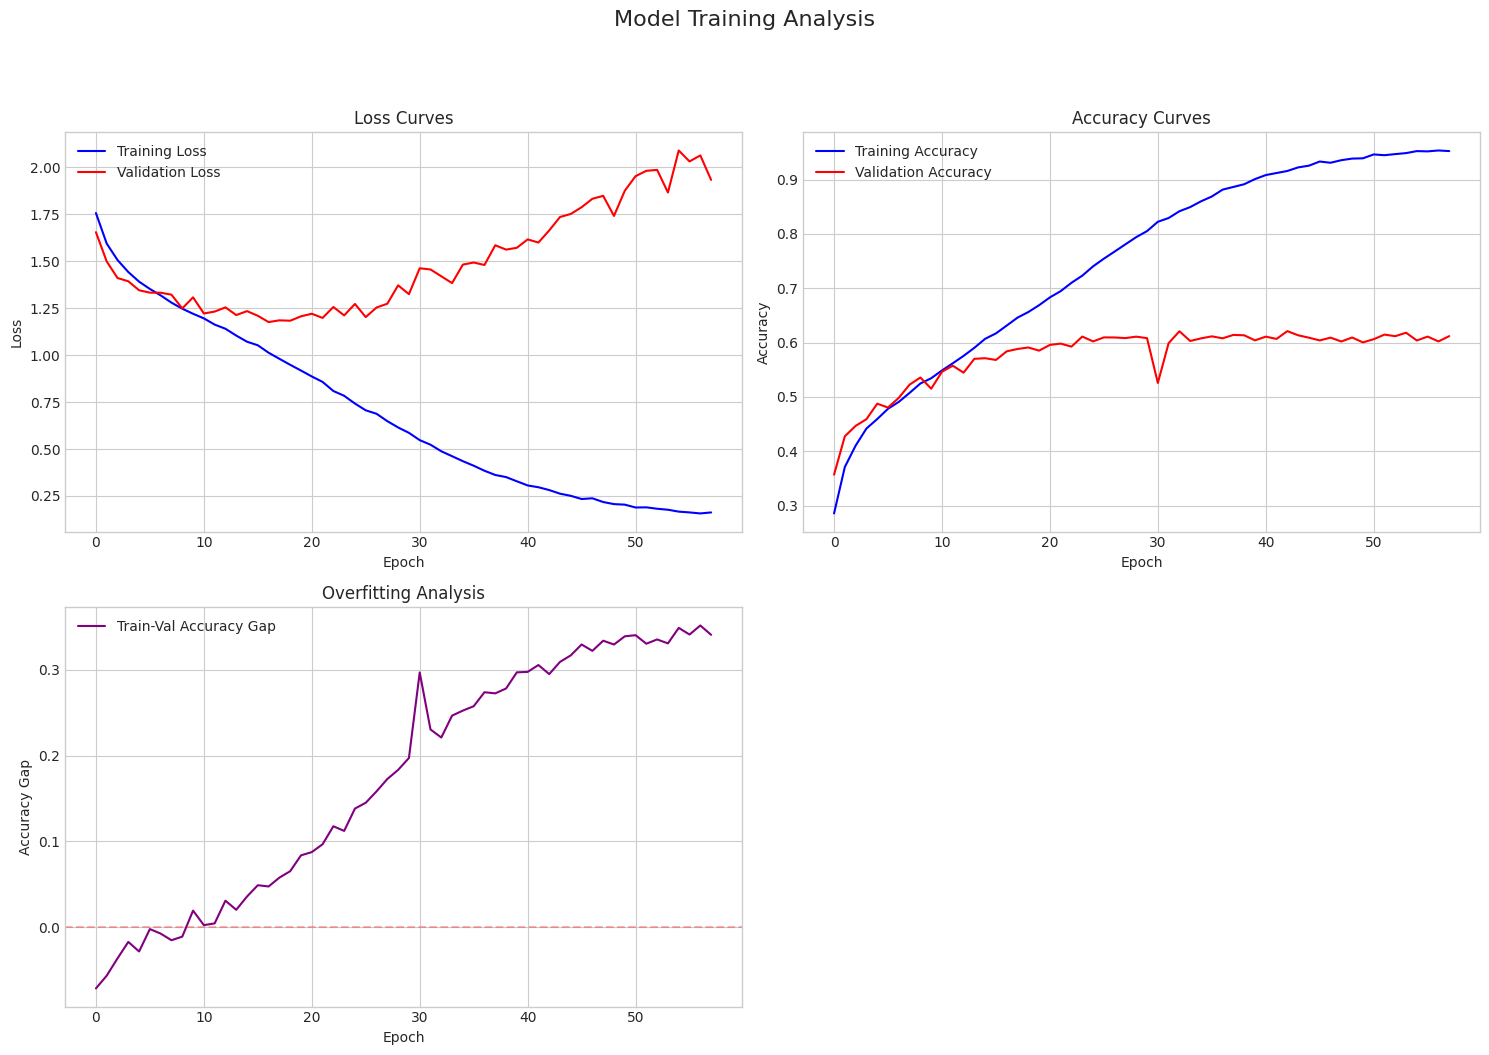

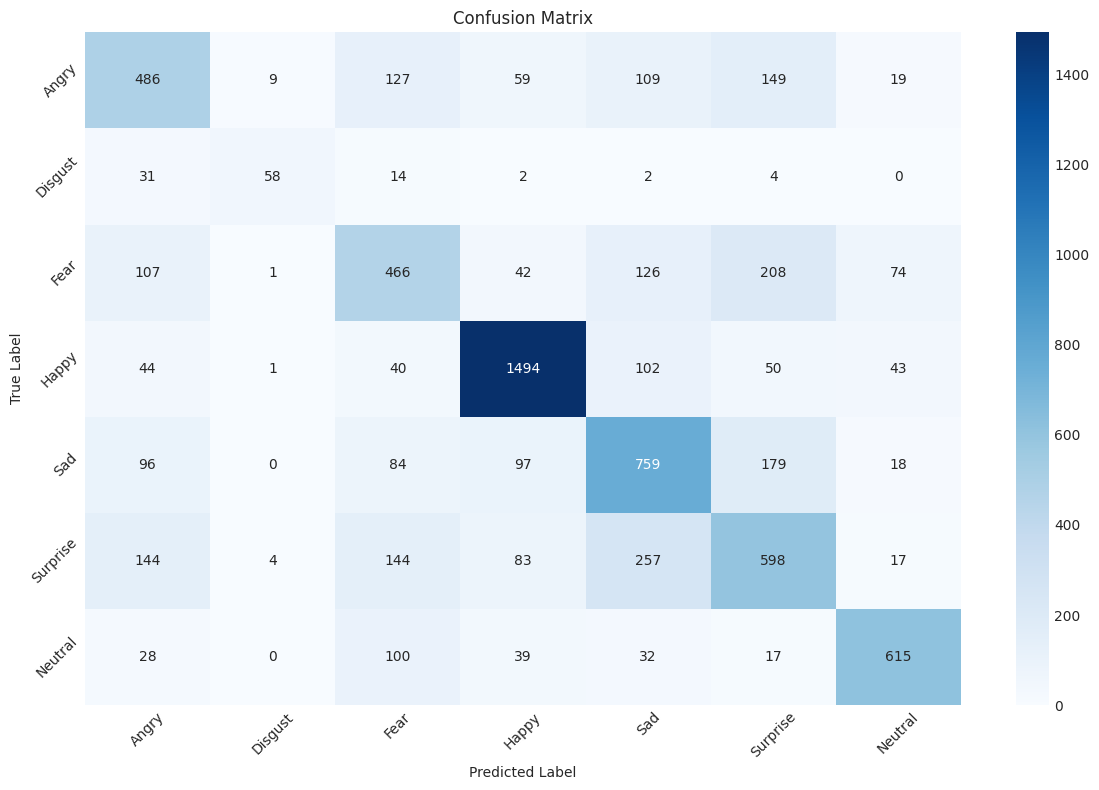


Classification Report:
              precision    recall  f1-score   support

       Angry       0.52      0.51      0.51       958
     Disgust       0.79      0.52      0.63       111
        Fear       0.48      0.46      0.47      1024
       Happy       0.82      0.84      0.83      1774
         Sad       0.55      0.62      0.58      1233
    Surprise       0.50      0.48      0.49      1247
     Neutral       0.78      0.74      0.76       831

    accuracy                           0.62      7178
   macro avg       0.63      0.59      0.61      7178
weighted avg       0.62      0.62      0.62      7178



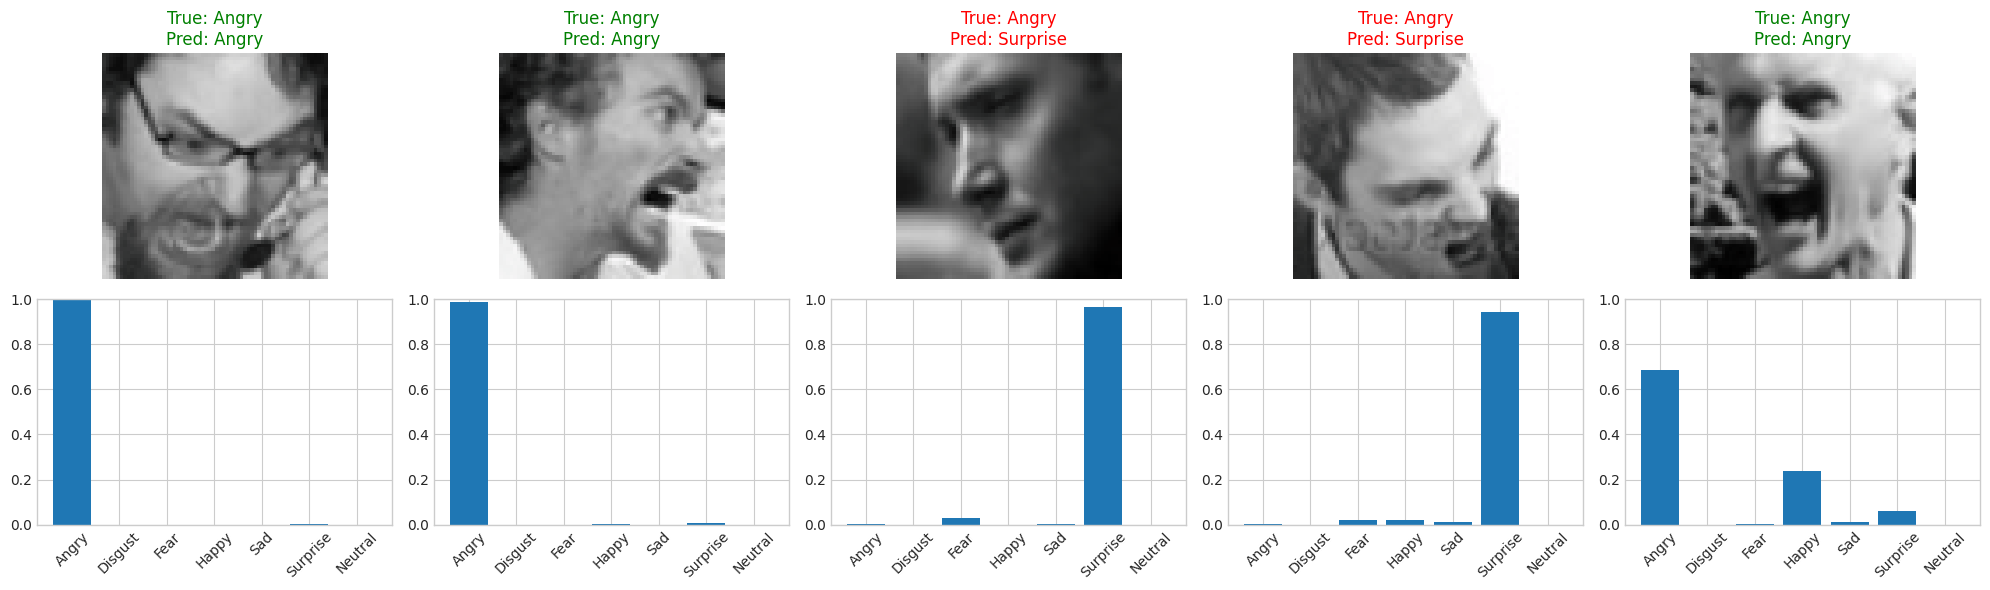

In [4]:
print_parameter_details(model)

pt_path, ptl_path = convert_all_formats('ResEmoteNetKAN_model.pth', 'ResEmoteNet')

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)